# VAE 

Variantional Auto Encoders

In [1]:
import torch
from  torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

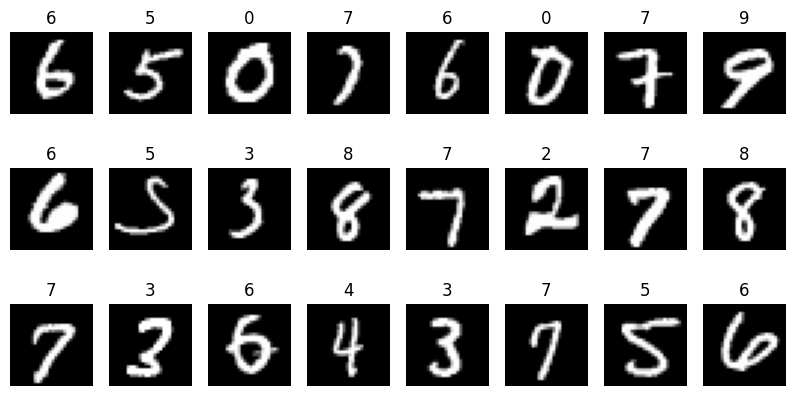

In [3]:
figure = plt.figure(figsize=(10, 5))
cols, rows = 8, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(*[label])
plt.show()

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


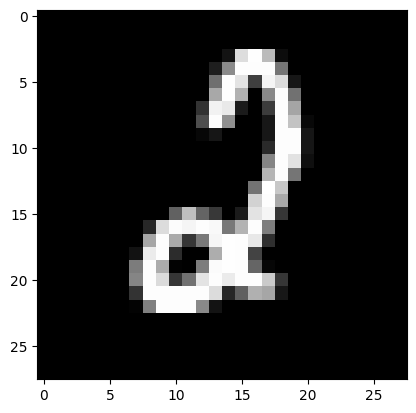

Label: 2


In [252]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
plt.imshow(img.squeeze(), cmap="gray")
plt.show()
print(f"Label: {label}")

In [9]:
indexes = torch.tensor([[0,3,5]])
indexes

tensor([[0, 3, 5]])

In [10]:
F.one_hot(indexes)

tensor([[[1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 1]]])

In [130]:
from torchvision.transforms import ToTensor, Lambda

ds = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: F.one_hot(torch.tensor(y),10))
)


In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [142]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.mlp(x)
        return logits

model = MLP()

Predicted class: tensor([0])


(-1.0, 10.0)

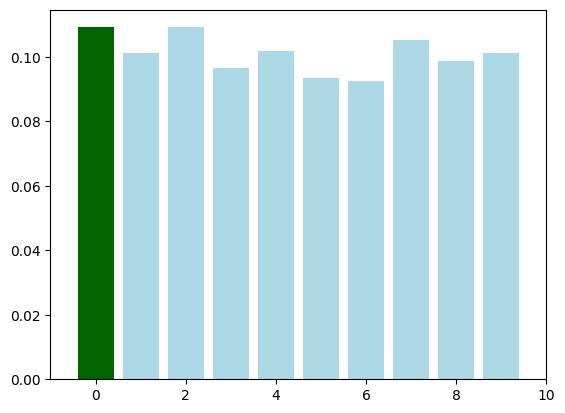

In [342]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)

pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

plt.bar(torch.arange(0,10,1).numpy(), class_probabilities[0], color='lightblue')
plt.bar(y_pred.numpy(), class_probabilities[0], color='darkgreen')
plt.xlim(-1,10)

In [221]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: mlp.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0252,  0.0099,  0.0118,  ..., -0.0243, -0.0335,  0.0354],
        [ 0.0057, -0.0331,  0.0292,  ..., -0.0035,  0.0293,  0.0318]],
       grad_fn=<SliceBackward0>) 

Layer: mlp.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0357, -0.0353], grad_fn=<SliceBackward0>) 

Layer: mlp.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0010,  0.0096,  0.0205,  ..., -0.0186,  0.0084, -0.0171],
        [-0.0193, -0.0115, -0.0012,  ..., -0.0434, -0.0351,  0.0419]],
       grad_fn=<SliceBackward0>) 

Layer: mlp.2.bias | Size: torch.Size([512]) | Values : tensor([-0.0332,  0.0441], grad_fn=<SliceBack

In [13]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [14]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

NameError: name 'model' is not defined

In [225]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [226]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297077  [   64/60000]
loss: 2.296778  [ 6464/60000]
loss: 2.291928  [12864/60000]
loss: 2.286646  [19264/60000]
loss: 2.289582  [25664/60000]
loss: 2.285011  [32064/60000]
loss: 2.278069  [38464/60000]
loss: 2.270872  [44864/60000]
loss: 2.270276  [51264/60000]
loss: 2.268898  [57664/60000]
Test Error: 
 Accuracy: 47.5%, Avg loss: 2.258509 

Epoch 2
-------------------------------
loss: 2.253000  [   64/60000]
loss: 2.252002  [ 6464/60000]
loss: 2.254601  [12864/60000]
loss: 2.236760  [19264/60000]
loss: 2.247363  [25664/60000]
loss: 2.225954  [32064/60000]
loss: 2.222237  [38464/60000]
loss: 2.219238  [44864/60000]
loss: 2.212345  [51264/60000]
loss: 2.186172  [57664/60000]
Test Error: 
 Accuracy: 63.4%, Avg loss: 2.197308 

Epoch 3
-------------------------------
loss: 2.202908  [   64/60000]
loss: 2.167323  [ 6464/60000]
loss: 2.184607  [12864/60000]
loss: 2.147844  [19264/60000]
loss: 2.168931  [25664/60000]
loss: 2.159823  [32064/600

Predicted class: tensor([2])


(-1.0, 10.0)

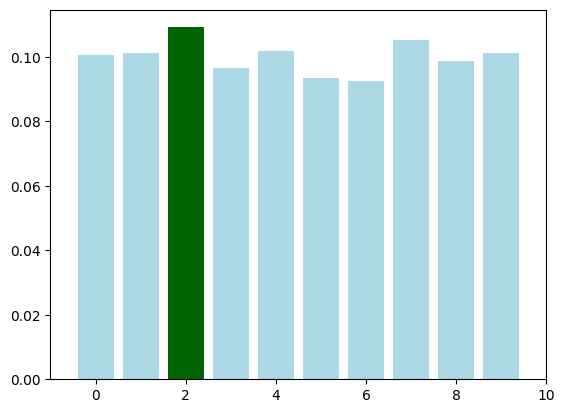

In [227]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)

pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

plt.bar(torch.arange(0,10,1).numpy(), class_probabilities[0], color='lightblue')
plt.bar(y_pred.numpy(), class_probabilities[0], color='darkgreen')
plt.xlim(-1,10)

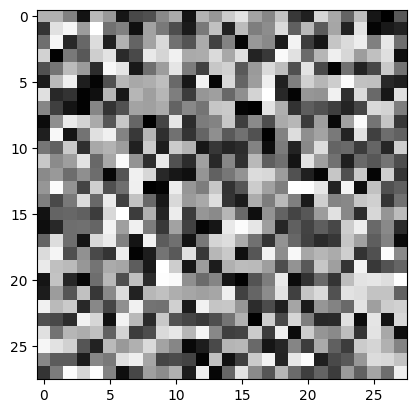

In [269]:
plt.imshow(X.view(28,28),cmap='gray')

In [311]:
import os
ROOT_PATH = "../../../mnt/c/Users/Asus/Pictures/"

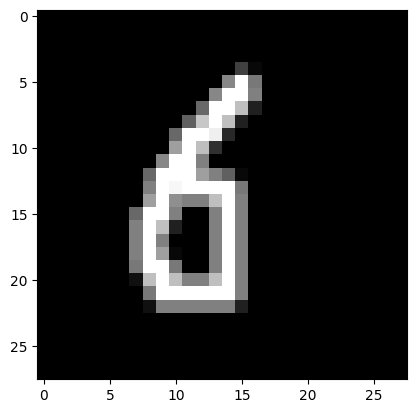

Predicted class: tensor([6])


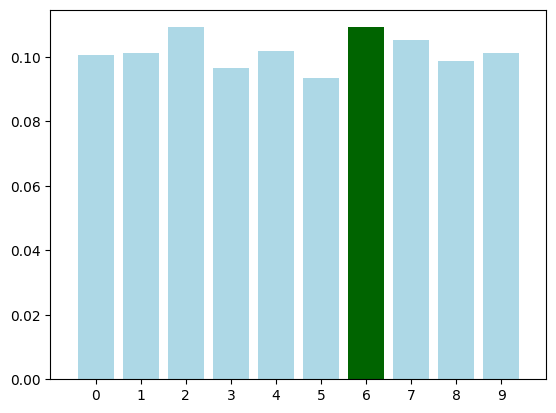

In [345]:
r = plt.imread(ROOT_PATH+"five.png")
r = torch.tensor(r)
r = r[:,:,1]
r  = 1-r

plt.imshow(r,cmap='gray')
plt.show()

logits = model(r.view(1,28,28))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

plt.bar(torch.arange(0,10,1).numpy(), class_probabilities[0], color='lightblue')
plt.bar(y_pred.numpy(), class_probabilities[0], color='darkgreen')
plt.xlim(-1,10)
plt.xticks(ticks=np.arange(0,10,1))
plt.show()

In [340]:
class VAE:
    def __init__(self,encoder, decoder,loss):
        self.encoder = encoder
        self.decoder = decoder
        self.loss = loss

    def forward(self,X):
        z = self.encoder(X)
        x = self.decoder(z)
        return x

class Encoder:
    def __init__(self):
        pass

    def forward(self,X):
        return X


class Decoder:
    def __init__(self):
        pass

    def forward(self,z):
        return z

In [70]:
x = torch.randn(1,1,100,100)

In [155]:
class Encoder(nn.Module):
    def __init__(self,fan_in: int,  conv_blocks: list[int]) -> None:
        super().__init__()
        self.conv_blocks = conv_blocks
        self.module_list = nn.ModuleList()

        self.input_channels = fan_in

        for fan_out in self.conv_blocks:
            self.module_list.append(nn.Conv2d(in_channels=fan_in,out_channels=fan_out,
                                               kernel_size=3,stride=1,padding=0,bias=False)
                                    )
            fan_in = fan_out
            
        self.linear = nn.Linear(100,10)


    def forward(self,X):
        res= X
        for layer in self.module_list:
            res = layer(res)
            print(res.shape)
            res = F.relu(res)
            
        
        print(res.view(1,-1).shape)
        return res
encoder = Encoder(1,[32,64,128,256,512])
encoder

Encoder(
  (module_list): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
  )
  (linear): Linear(in_features=100, out_features=10, bias=True)
)

In [156]:
x.shape

torch.Size([1, 1, 100, 100])

In [157]:
encoder(x);

torch.Size([1, 32, 98, 98])
torch.Size([1, 64, 96, 96])
torch.Size([1, 128, 94, 94])
torch.Size([1, 256, 92, 92])
torch.Size([1, 512, 90, 90])
torch.Size([1, 4147200])


In [158]:

100 * 4

400

In [401]:
# VAE for MNIST with MLP (treating linear inputs instead of image)
# 28* 28 > 784

class Encoder(nn.Module):
    def __init__(self, neurons=[784,400,400,4]):
        super(Encoder,self).__init__()

        self.module_list = nn.ModuleList()
        for fan_in, fan_out in zip(neurons,neurons[1:]):
            self.module_list.append(nn.Linear(fan_in, fan_out))

        self.mu = nn.Linear(fan_out, 2)
        self.log_var = nn.Linear(fan_out, 2)

    def forward(self, x):
        for layer in self.module_list:
            x = layer(x)
            x = F.sigmoid(x)
            # print(x.shape)
        mu = self.mu(x)
        log_var = self.log_var(x)
            
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, neurons=[2, 4, 400,400, 784]):
        super(Decoder,self).__init__()

        self.module_list = nn.ModuleList()
        for fan_in, fan_out in zip(neurons,neurons[1:]):
            self.module_list.append(nn.Linear(fan_in, fan_out))

    def forward(self, x):
        # x is z
        for i, layer in enumerate(self.module_list[:-1]):
            x = layer(x)
            x = F.relu(x)

        x = self.module_list[-1](x)
        x = F.sigmoid(x)

        return x

In [402]:
encoder = Encoder()
encoder

Encoder(
  (module_list): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=4, bias=True)
  )
  (mu): Linear(in_features=4, out_features=2, bias=True)
  (log_var): Linear(in_features=4, out_features=2, bias=True)
)

In [403]:
# x = torch.randn(1,784)

In [404]:
mu, log_var = encoder(img.view(1,-1))

In [405]:
mu, log_var

(tensor([[0.1631, 0.2852]], grad_fn=<AddmmBackward0>),
 tensor([[0.1355, 0.4876]], grad_fn=<AddmmBackward0>))

In [406]:
# eps = torch.randn_like(mu)
eps

tensor([[0.2936, 0.2725]])

In [407]:
z = mu + log_var * eps
z.shape


torch.Size([1, 2])

In [408]:
decoder = Decoder()
decoder

Decoder(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): Linear(in_features=400, out_features=784, bias=True)
  )
)

In [409]:
x_hat = decoder(z)
x_hat.shape

torch.Size([1, 784])

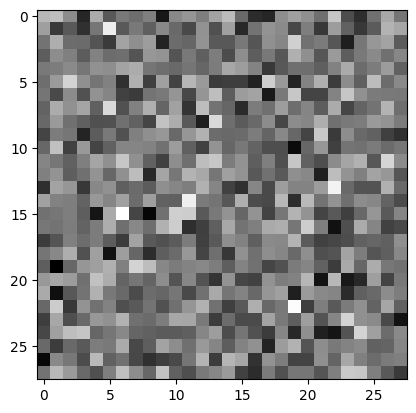

In [410]:
plt.imshow(x_hat.view(28,28,1).detach().numpy(),'gray')

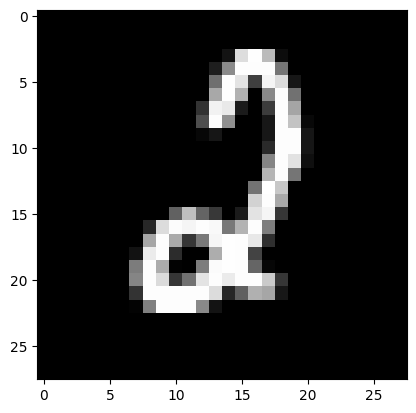

In [411]:
img

plt.imshow(img.view(28,28,1).detach().numpy(),'gray')

In [412]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)   
        z = mean + var*epsilon
        return z
        

    def forward(self, x):
        # x = torch.flatten(x,1)
        mu, log_var = self.encoder(x)
        z = self.reparameterization(mu, log_var)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

In [413]:
model = VAE(Encoder(), Decoder())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [414]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [422]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_dataloader):
            # print(batch_idx)
            # print(x.shape)
            x = x.view(-1,784).to(device)
            # print(x.shape)
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            # break
            

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=200, device=device)

	Epoch 1 	Average Loss:  135.26146228183677
	Epoch 2 	Average Loss:  134.74867651582147
	Epoch 3 	Average Loss:  134.42805760240097
	Epoch 4 	Average Loss:  134.5634996542427
	Epoch 5 	Average Loss:  134.32069427913638
	Epoch 6 	Average Loss:  134.02552657804213
	Epoch 7 	Average Loss:  133.9149047012899
	Epoch 8 	Average Loss:  133.80001559913984
	Epoch 9 	Average Loss:  133.70071778353403
	Epoch 10 	Average Loss:  133.61238526432848
	Epoch 11 	Average Loss:  133.65052439995992
	Epoch 12 	Average Loss:  133.27706835898417
	Epoch 13 	Average Loss:  132.95984126918472
	Epoch 14 	Average Loss:  132.96311772365834
	Epoch 15 	Average Loss:  132.6943428177971
	Epoch 16 	Average Loss:  132.5876873183276
	Epoch 17 	Average Loss:  132.51077009952184
	Epoch 18 	Average Loss:  132.4742407539229
	Epoch 19 	Average Loss:  133.4836867504466
	Epoch 20 	Average Loss:  134.0572832121793
	Epoch 21 	Average Loss:  132.3650205809635
	Epoch 22 	Average Loss:  131.89174132209703
	Epoch 23 	Average Loss:  1

7531515.386962891

In [423]:
torch.save(model,'vae')

model2 = torch.load('vae')

/tmp/ipykernel_25004/3508477678.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2 = torch.load('vae')


In [424]:
model2

VAE(
  (encoder): Encoder(
    (module_list): ModuleList(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): Linear(in_features=400, out_features=400, bias=True)
      (2): Linear(in_features=400, out_features=4, bias=True)
    )
    (mu): Linear(in_features=4, out_features=2, bias=True)
    (log_var): Linear(in_features=4, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (module_list): ModuleList(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=400, bias=True)
      (2): Linear(in_features=400, out_features=400, bias=True)
      (3): Linear(in_features=400, out_features=784, bias=True)
    )
  )
)

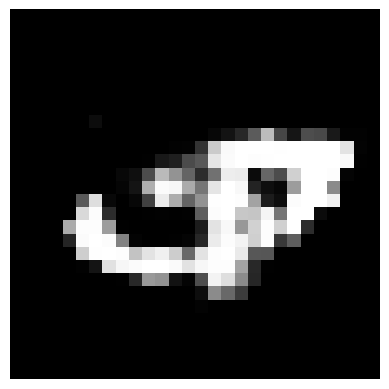

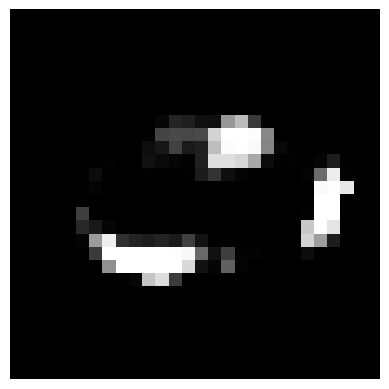

(None, None)

In [458]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model2.decoder(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

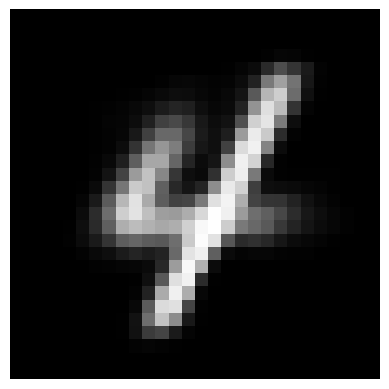

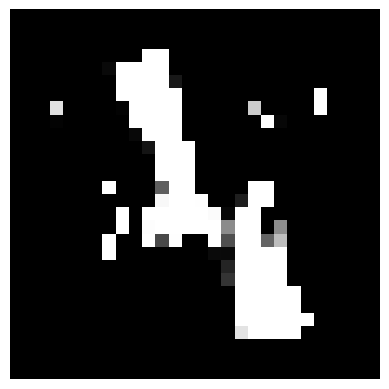

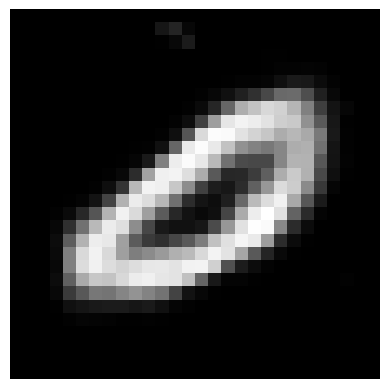

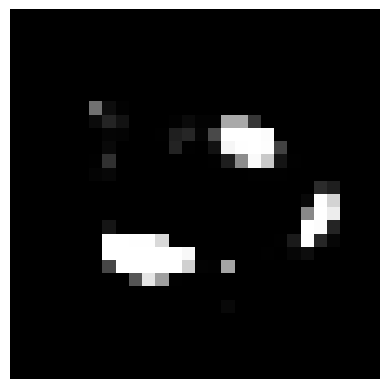

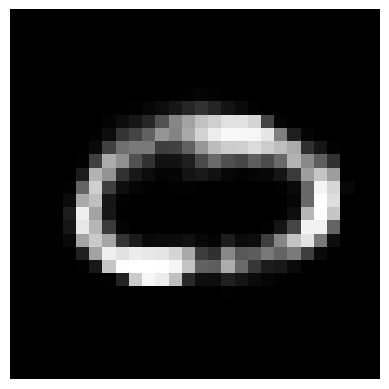

In [485]:
for i in range(5):
    generate_digit(torch.randn(1),torch.randn(1))

In [460]:
import numpy as np

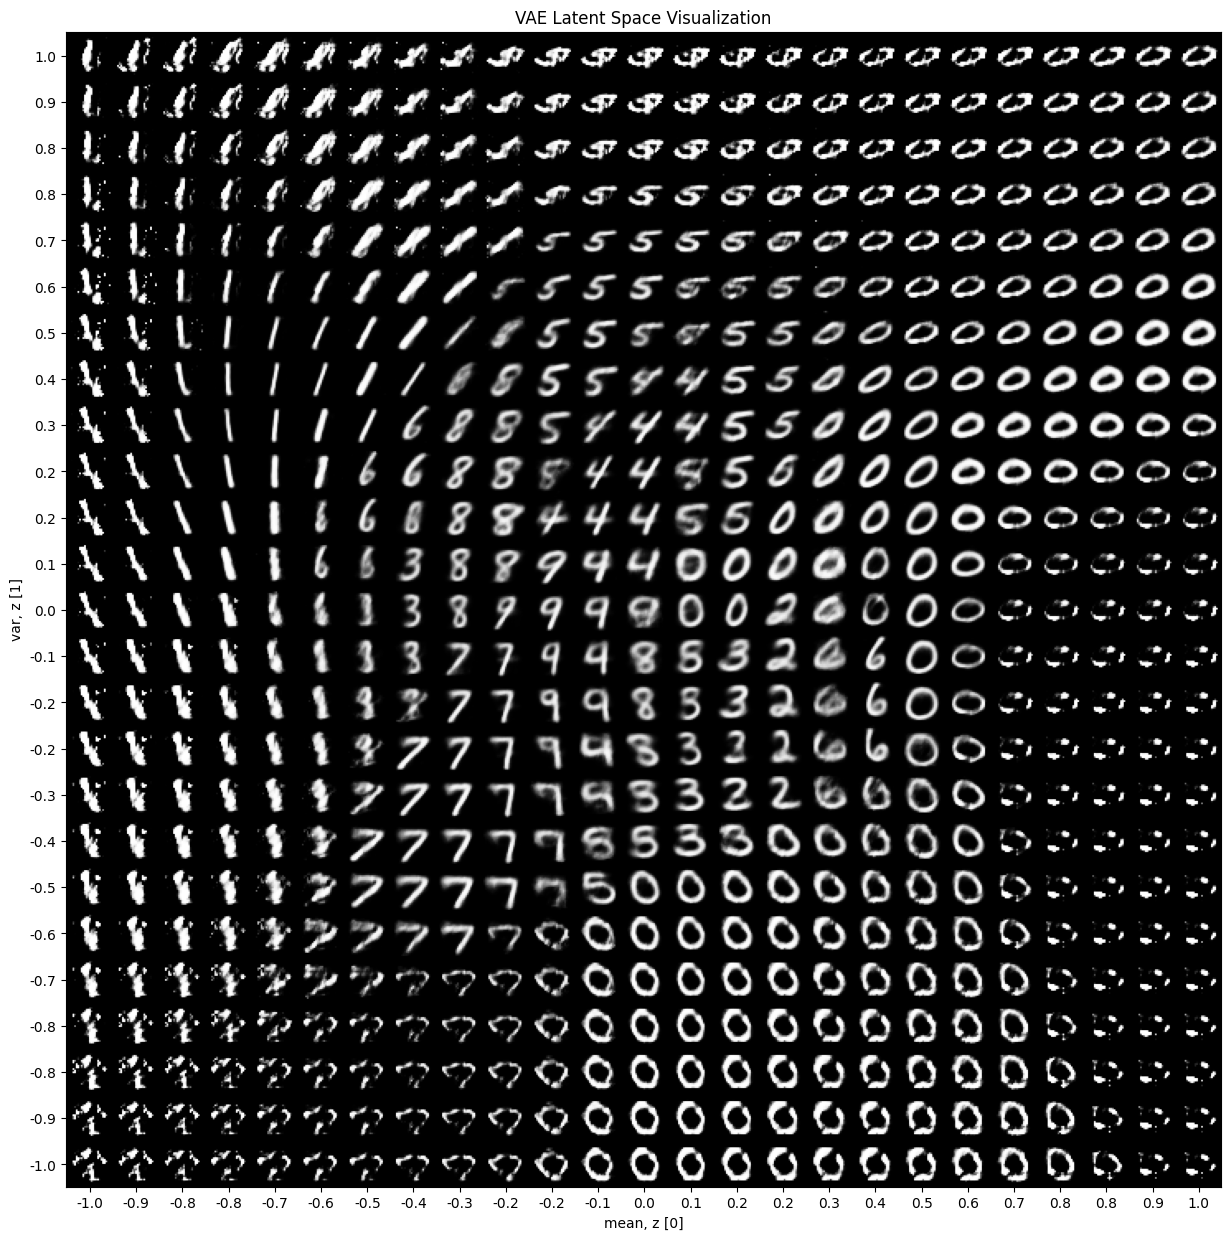

In [461]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

In [462]:
next(model.encoder.mu.parameters())

Parameter containing:
tensor([[-0.3090,  0.0688, -0.5372,  0.5797],
        [-0.1001,  0.6425,  0.4356,  0.2005]], requires_grad=True)

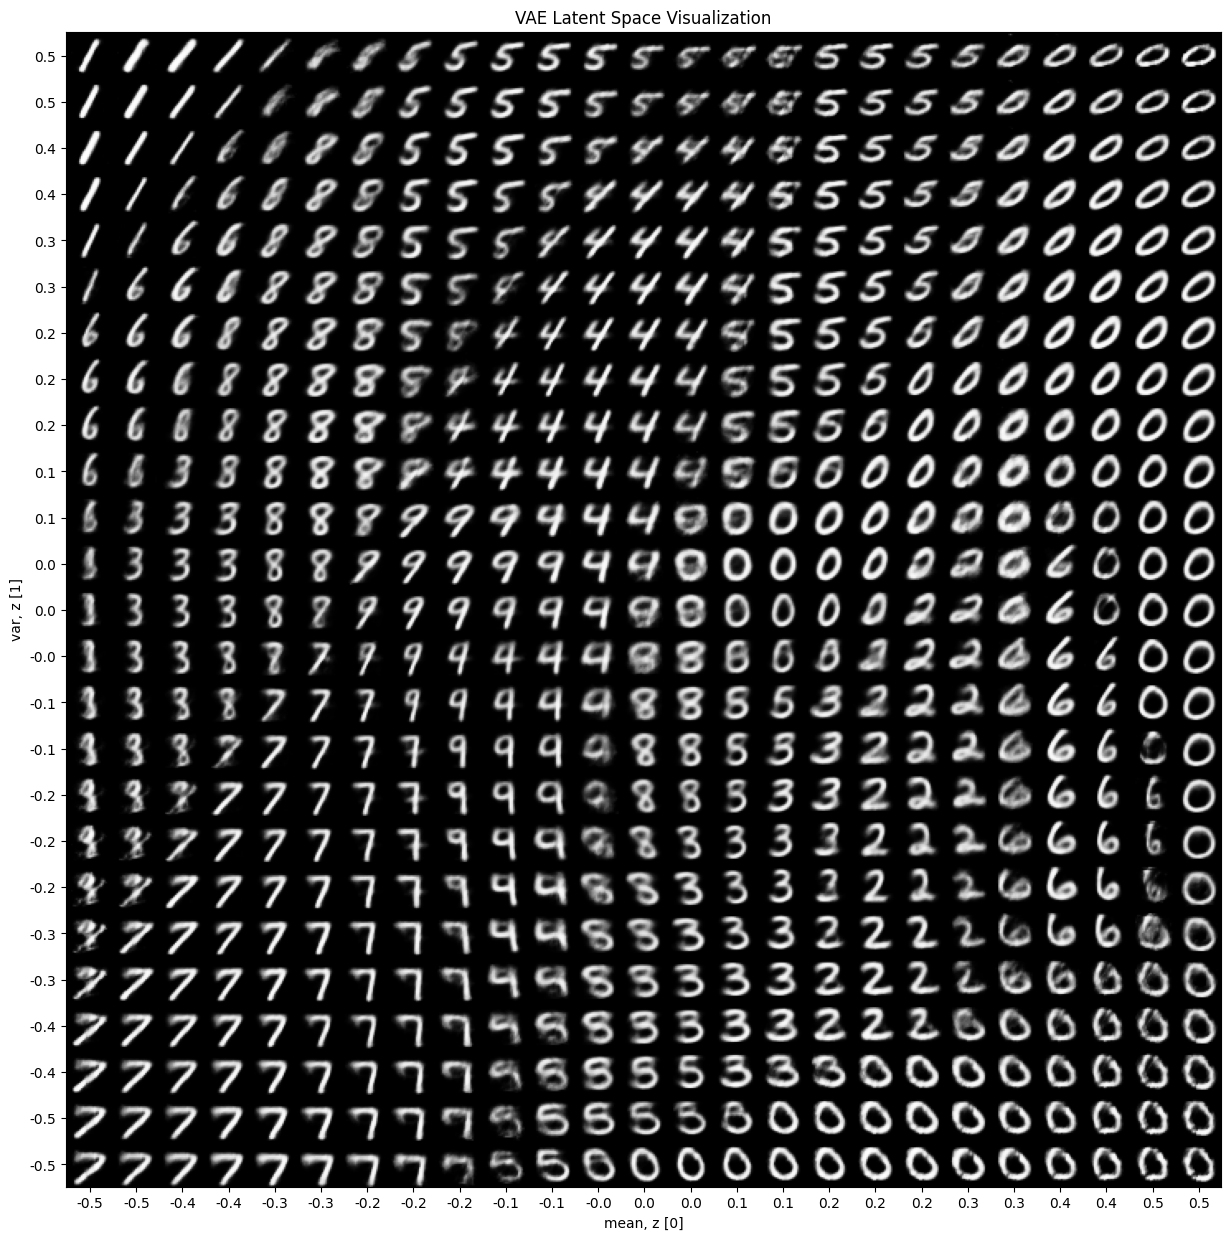

In [463]:
plot_latent_space(model2,scale=0.5)

In [484]:
mu = (torch.randn(1) +0.5 )/ (0.5 +0.5); var = (torch.randn(1) +0.5 )/ (0.5 +0.5)
mu, var

(tensor([0.8377]), tensor([1.4536]))

tensor([-1.4748]) tensor([0.8167])


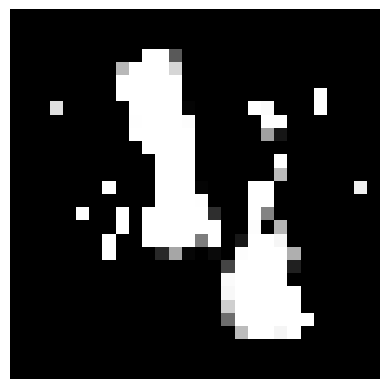

tensor([-0.3018]) tensor([-0.5149])


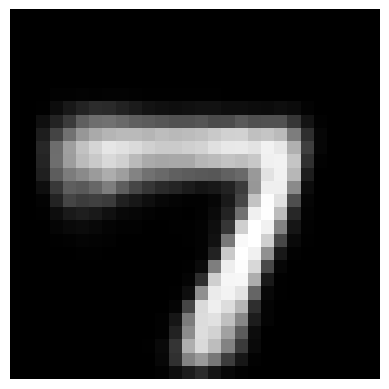

tensor([-0.0955]) tensor([0.6998])


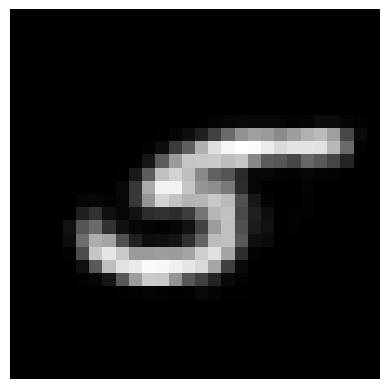

tensor([1.4588]) tensor([-2.3890])


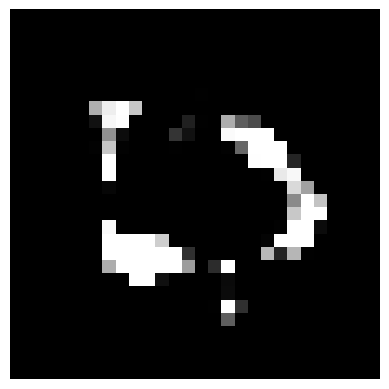

tensor([1.0938]) tensor([-0.6424])


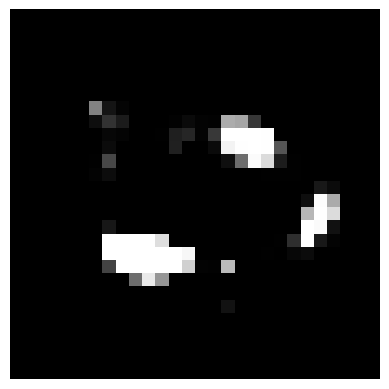

tensor([2.1139]) tensor([1.8195])


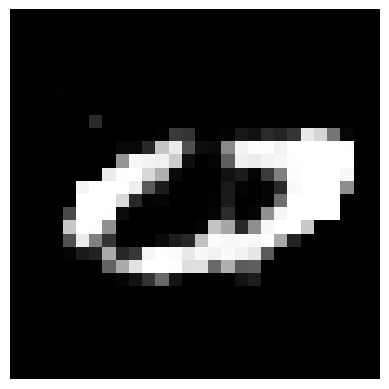

tensor([0.8896]) tensor([0.4912])


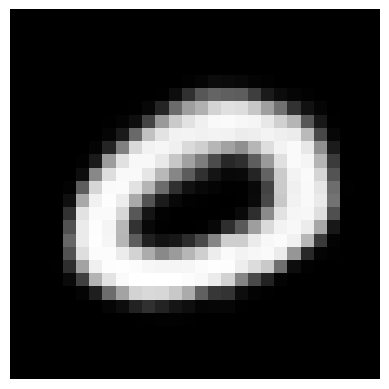

tensor([1.4401]) tensor([1.1228])


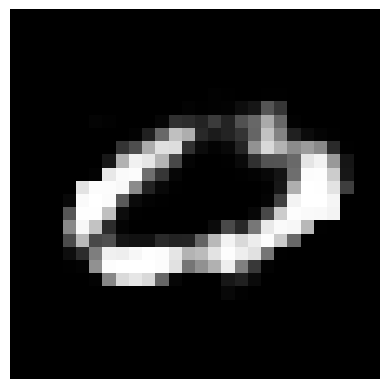

tensor([0.1927]) tensor([0.0766])


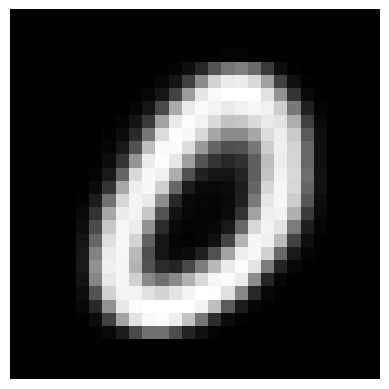

tensor([-0.7170]) tensor([-0.2515])


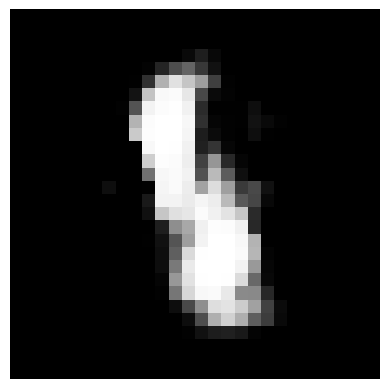

tensor([0.9527]) tensor([-1.3838])


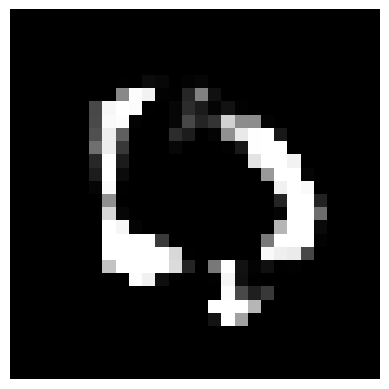

tensor([2.2173]) tensor([0.4555])


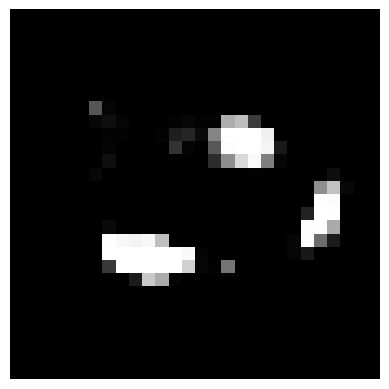

tensor([0.8958]) tensor([0.0970])


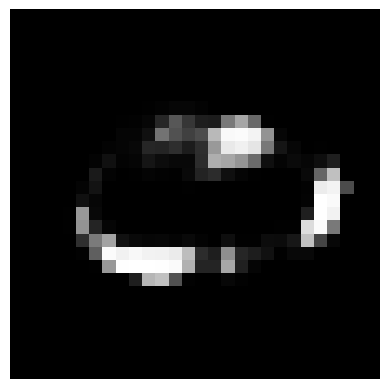

tensor([0.9738]) tensor([1.2711])


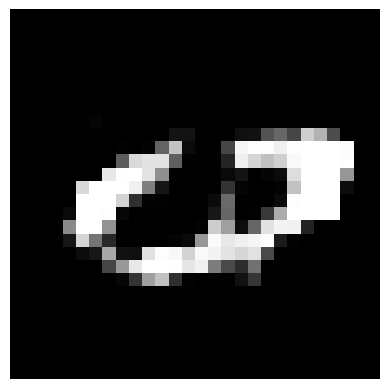

tensor([1.1287]) tensor([2.2557])


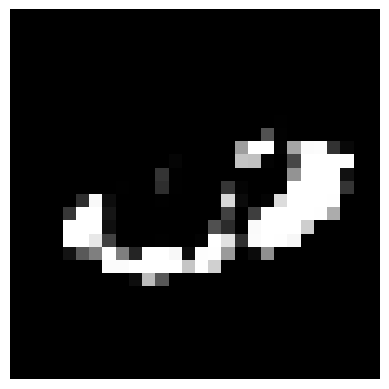

tensor([-0.3033]) tensor([0.8254])


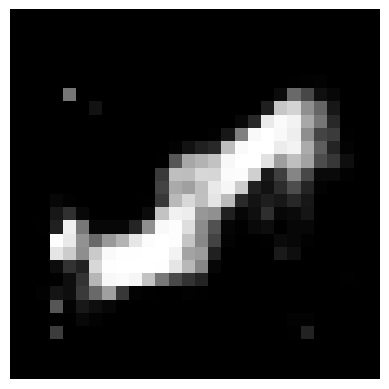

tensor([0.7829]) tensor([-0.4384])


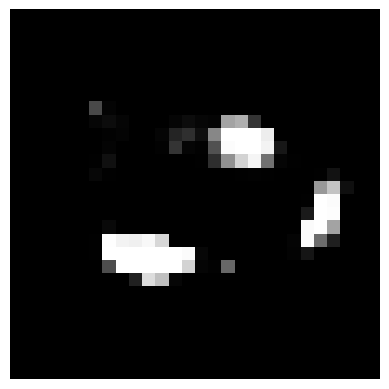

tensor([0.1443]) tensor([1.0431])


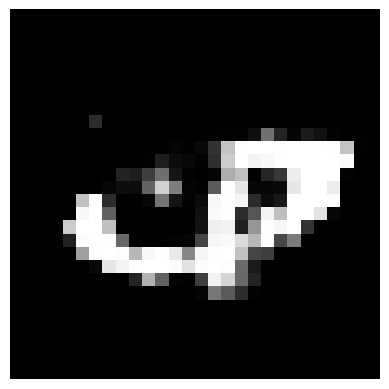

tensor([1.4446]) tensor([0.5778])


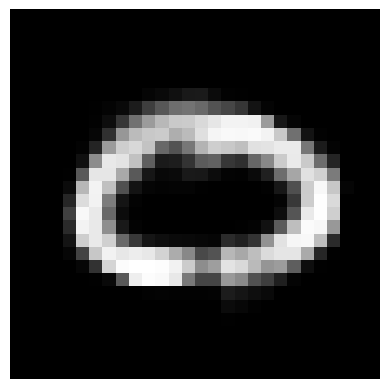

tensor([1.5823]) tensor([2.1268])


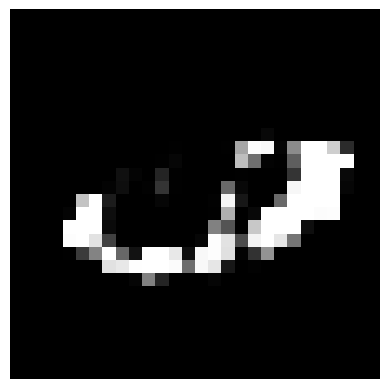

tensor([0.6485]) tensor([0.2355])


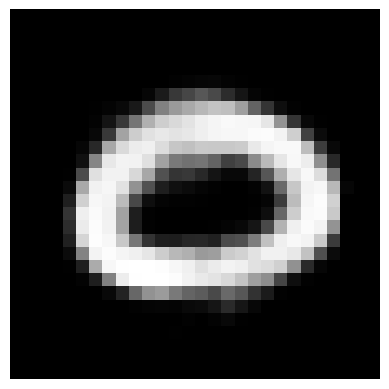

tensor([-0.6330]) tensor([1.1373])


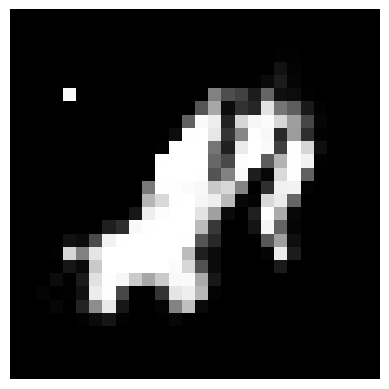

tensor([0.5274]) tensor([0.7518])


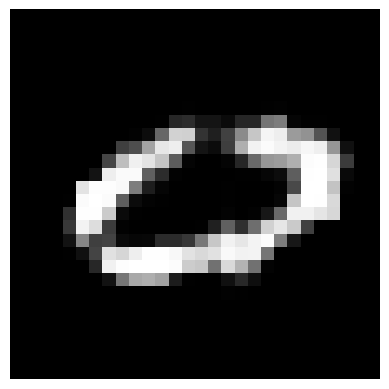

tensor([-0.7005]) tensor([0.0415])


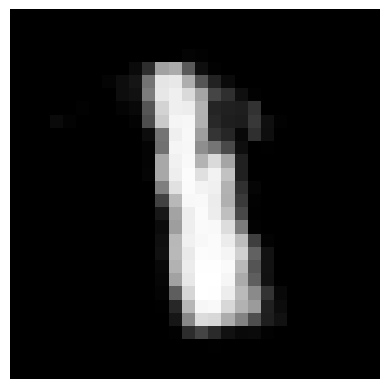

tensor([0.1572]) tensor([0.3250])


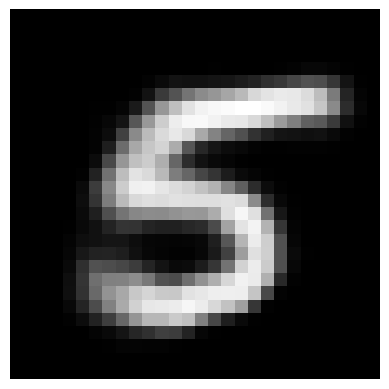

tensor([0.7741]) tensor([0.7355])


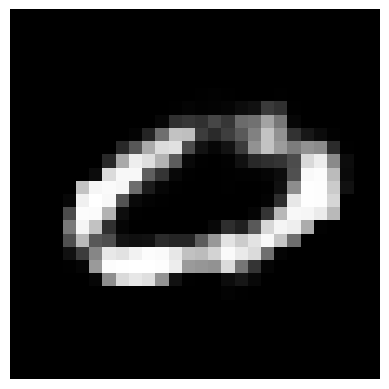

tensor([0.1873]) tensor([0.0458])


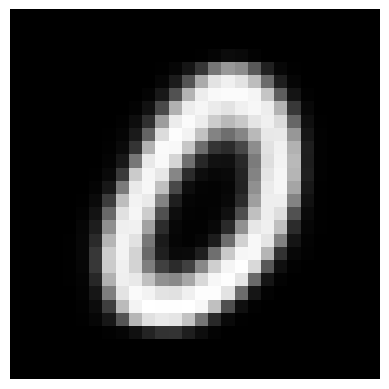

tensor([2.5216]) tensor([-0.2555])


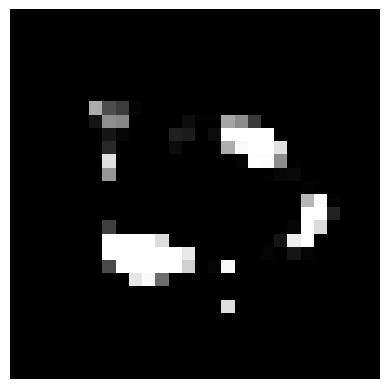

tensor([1.5762]) tensor([1.1139])


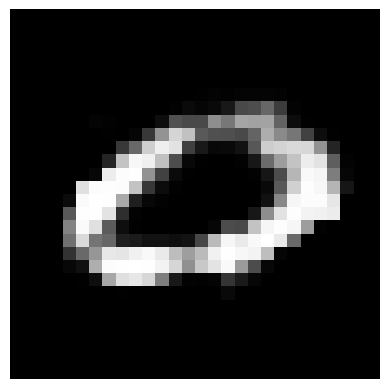

tensor([2.1860]) tensor([0.6093])


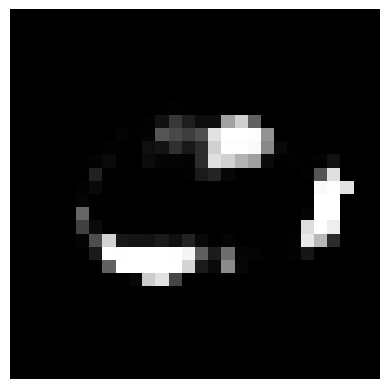

tensor([0.3914]) tensor([0.4743])


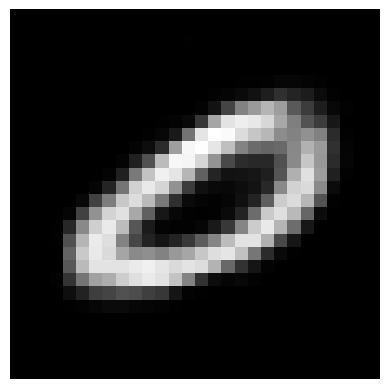

tensor([1.2034]) tensor([-0.5766])


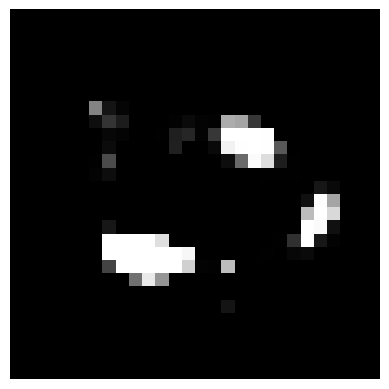

tensor([0.5791]) tensor([0.6260])


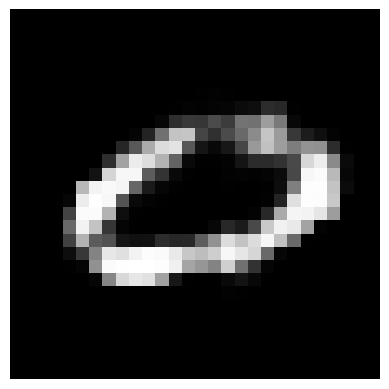

tensor([-0.2176]) tensor([-0.3658])


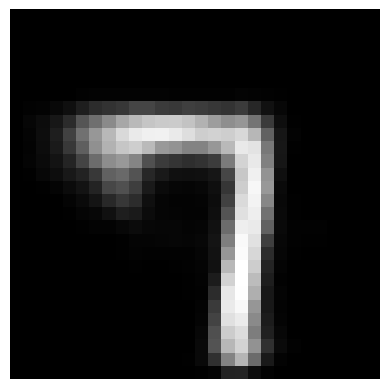

tensor([1.8285]) tensor([1.6336])


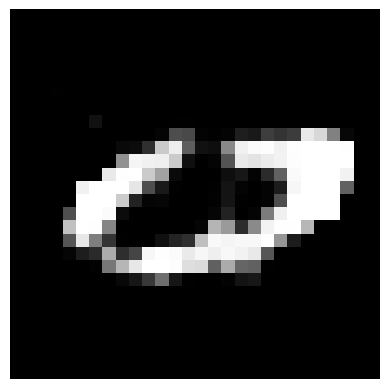

tensor([2.1319]) tensor([-0.7724])


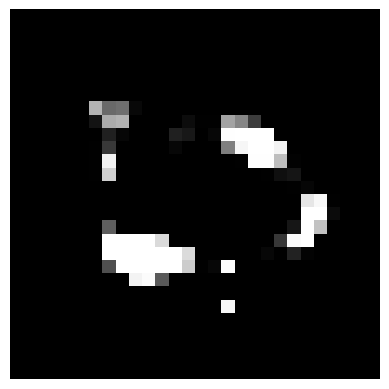

tensor([1.7101]) tensor([0.3347])


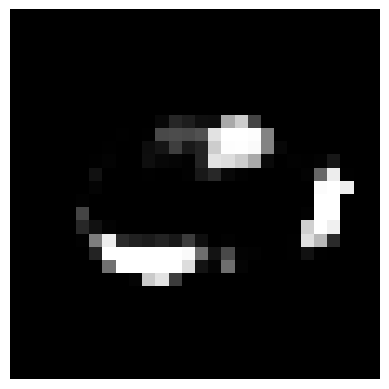

tensor([0.0896]) tensor([0.1372])


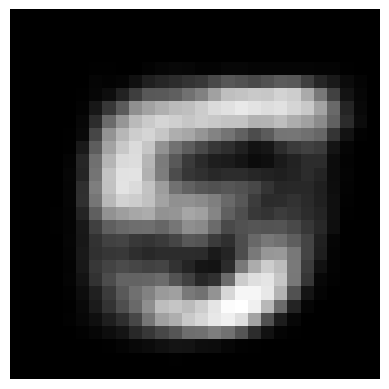

tensor([0.2345]) tensor([0.6404])


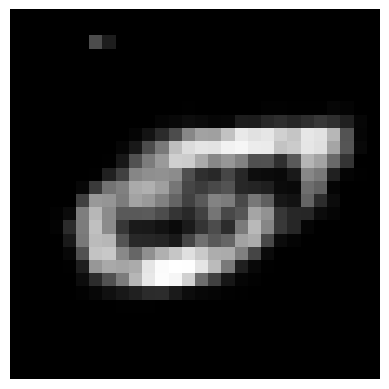

tensor([0.6467]) tensor([0.9034])


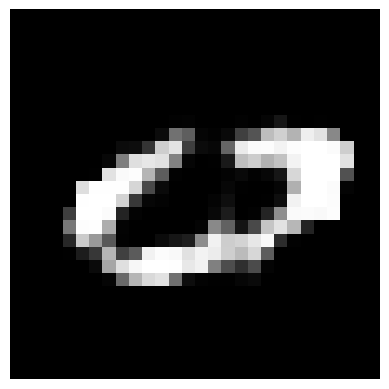

tensor([-0.0166]) tensor([-1.5773])


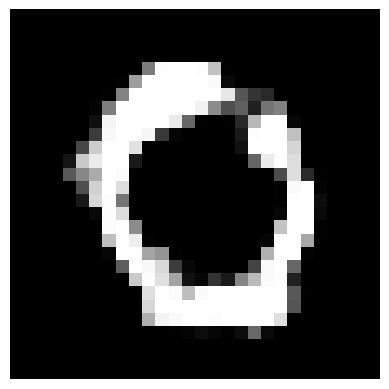

tensor([-0.0195]) tensor([0.2879])


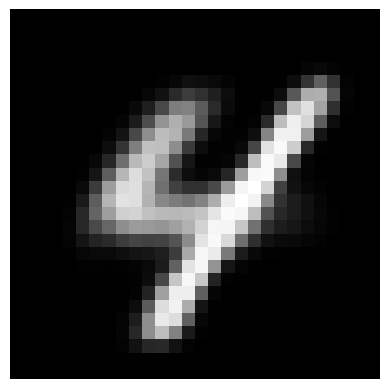

tensor([-0.4293]) tensor([1.2306])


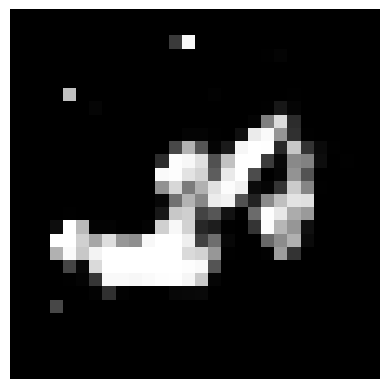

tensor([0.0822]) tensor([1.3495])


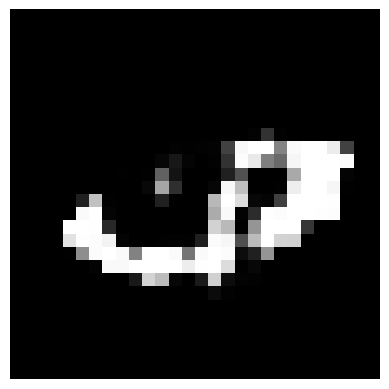

tensor([0.0565]) tensor([1.0444])


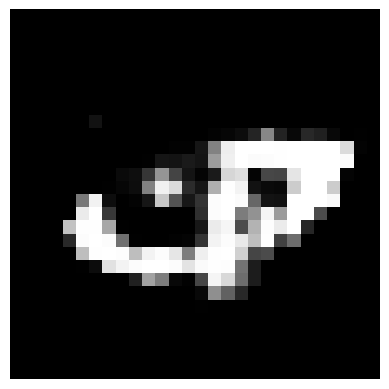

tensor([-0.4533]) tensor([1.4438])


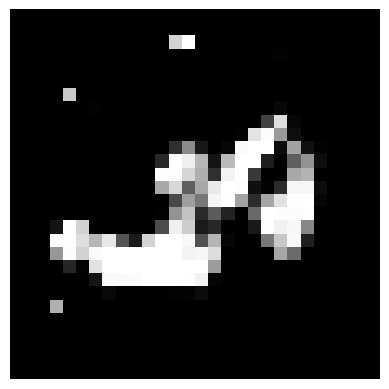

tensor([-0.1181]) tensor([0.3942])


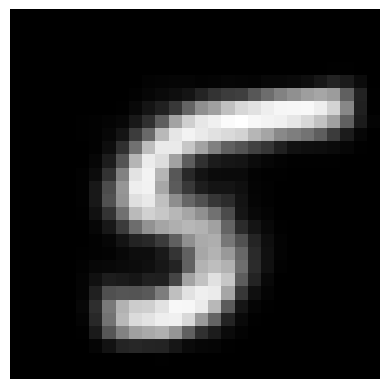

tensor([0.1004]) tensor([0.9779])


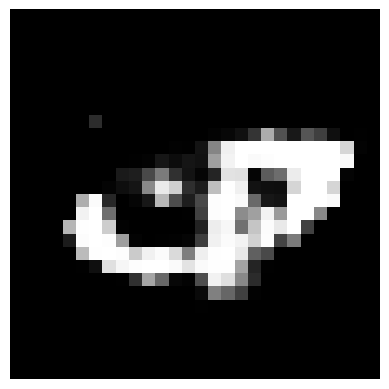

tensor([-0.8633]) tensor([1.8836])


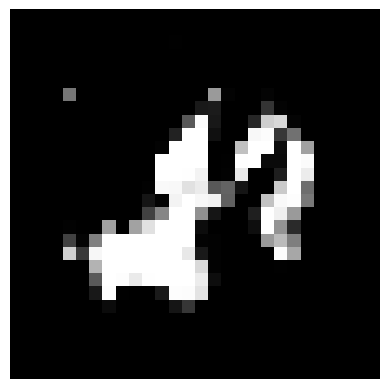

tensor([-0.4592]) tensor([0.4312])


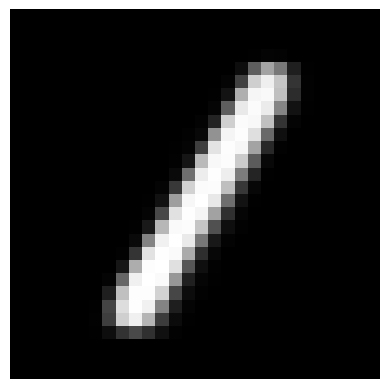

In [493]:
import torch

# Parameters for the normal distribution
mean = 0.0
std = 0.2  # Adjust standard deviation to control spread

# Generate random normal values
values = torch.normal(mean, std, size=(2,))  # Adjust size as needed

# Optional: Clip to restrict values strictly within -0.5 to 0.5
clipped_values = torch.clamp(values, min=-0.5, max=0.5)

# Display some values
print(clipped_values[:10])


tensor([-0.2154, -0.2040])


tensor(0.0908) tensor(-0.0801)


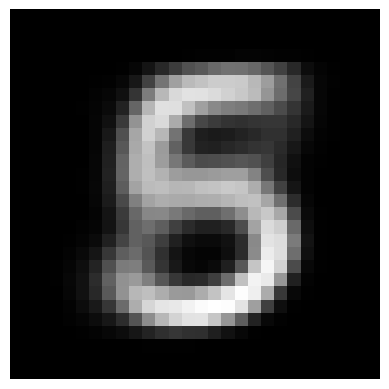

tensor(-0.0884) tensor(-0.0562)


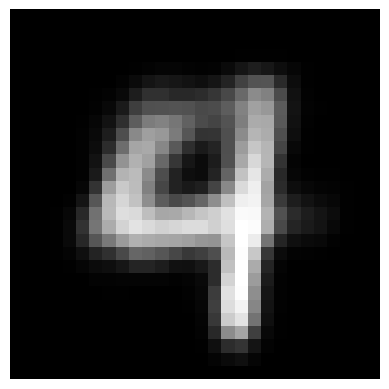

tensor(-0.3036) tensor(0.0577)


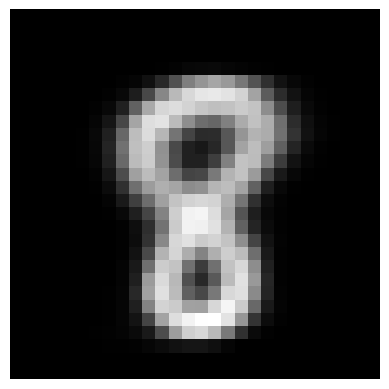

tensor(0.1428) tensor(-0.0401)


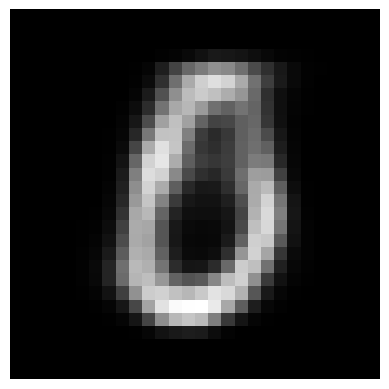

tensor(-0.0264) tensor(-0.0759)


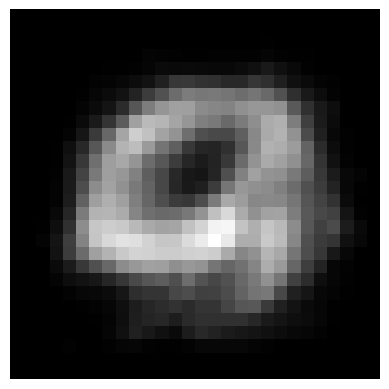

tensor(-0.1969) tensor(-0.4213)


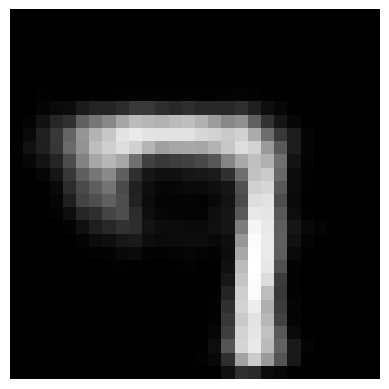

tensor(-0.4583) tensor(0.0631)


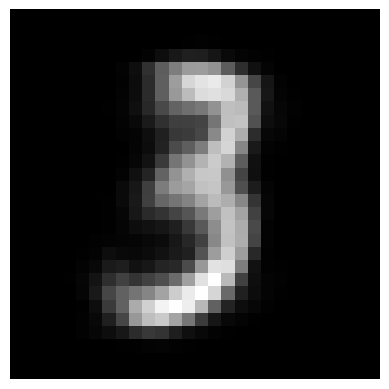

tensor(0.1134) tensor(-0.2572)


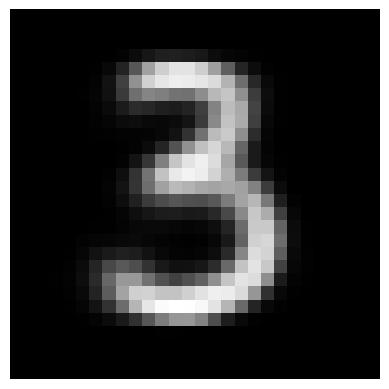

tensor(0.4546) tensor(0.2062)


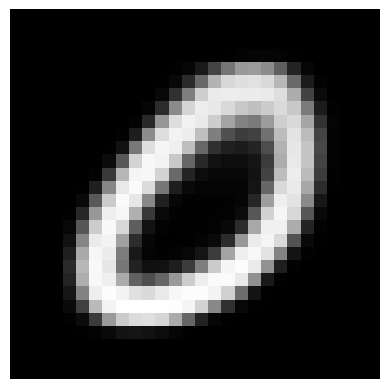

tensor(0.0208) tensor(0.0329)


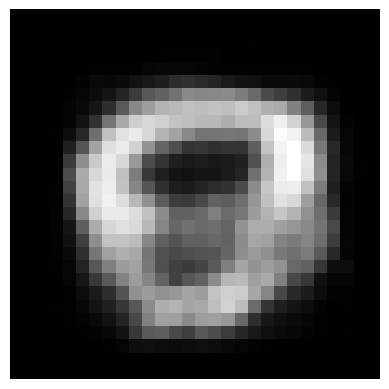

tensor(0.0213) tensor(0.1149)


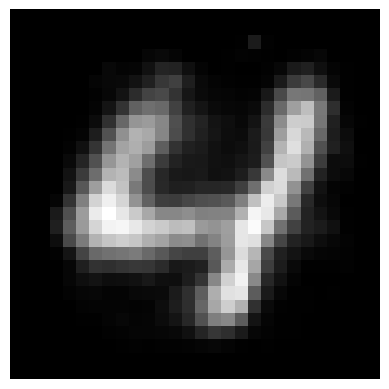

tensor(0.2322) tensor(-0.1750)


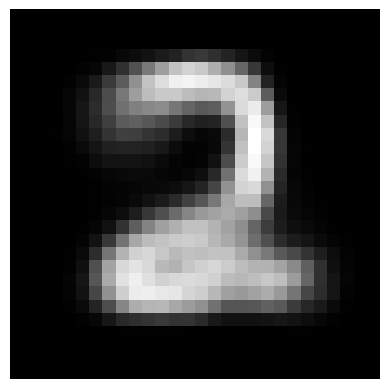

tensor(-0.0047) tensor(0.4117)


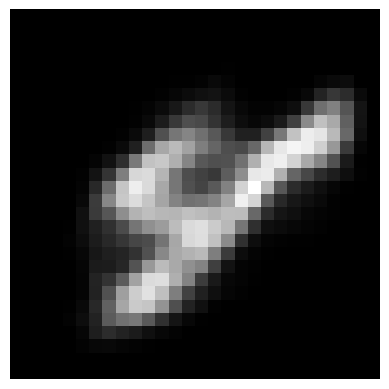

tensor(0.1888) tensor(-0.0662)


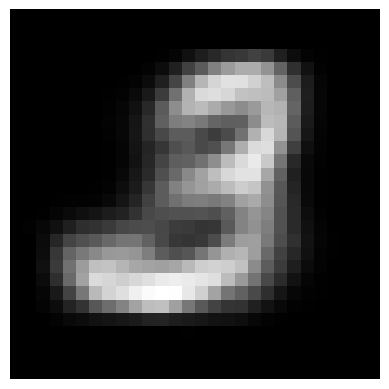

tensor(-0.3761) tensor(0.2218)


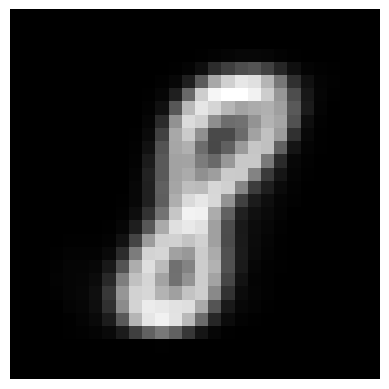

tensor(0.1765) tensor(-0.2976)


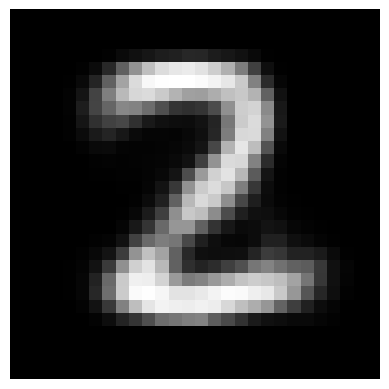

tensor(0.5000) tensor(-0.2278)


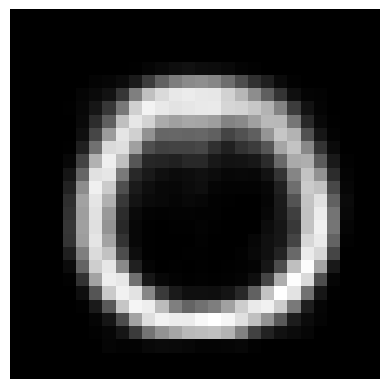

tensor(0.3127) tensor(-0.0579)


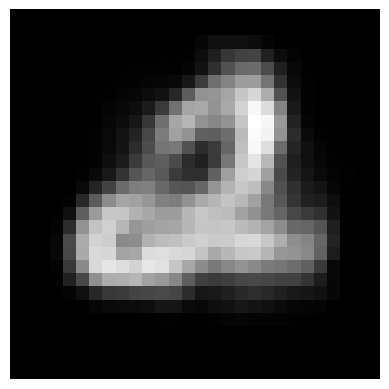

tensor(0.0048) tensor(0.1993)


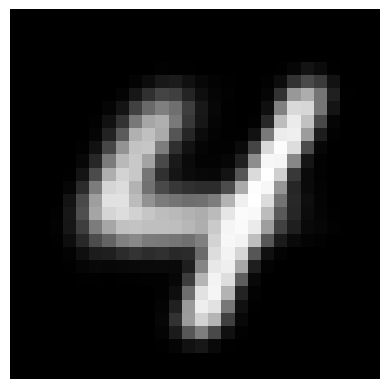

tensor(-0.2347) tensor(0.0496)


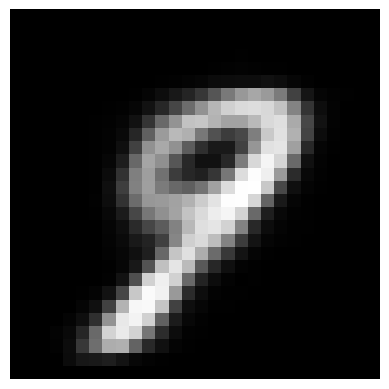

tensor(-0.0102) tensor(0.2555)


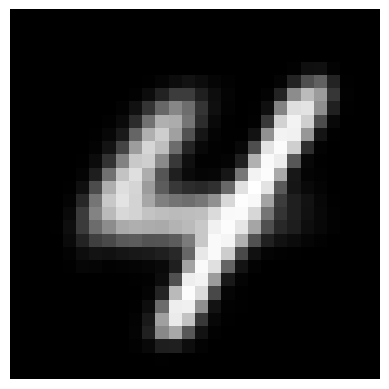

tensor(-0.3163) tensor(0.2009)


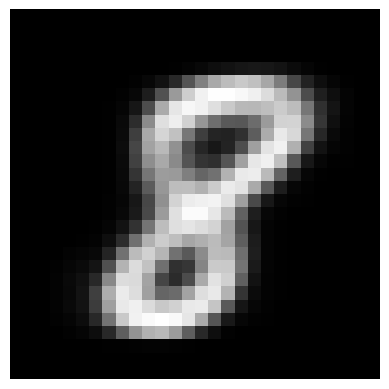

tensor(0.0605) tensor(0.1157)


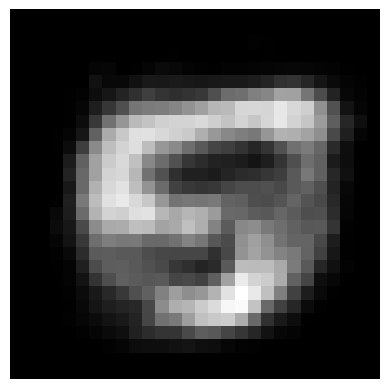

tensor(-0.0378) tensor(-0.0354)


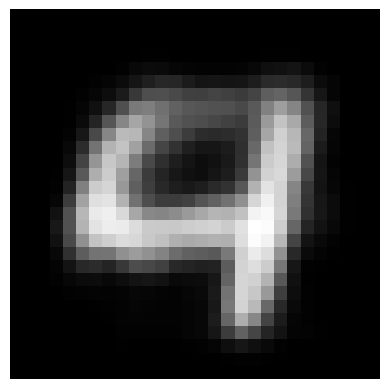

tensor(-0.0940) tensor(0.1355)


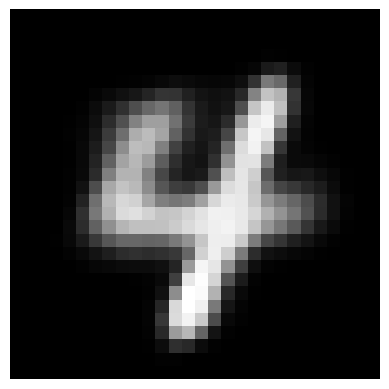

tensor(0.0870) tensor(-0.0084)


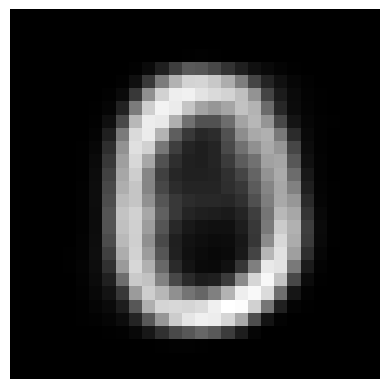

tensor(0.0577) tensor(-0.0156)


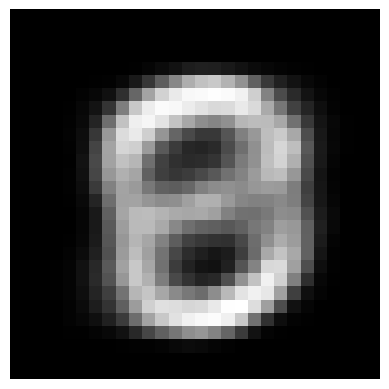

tensor(-0.0710) tensor(0.2775)


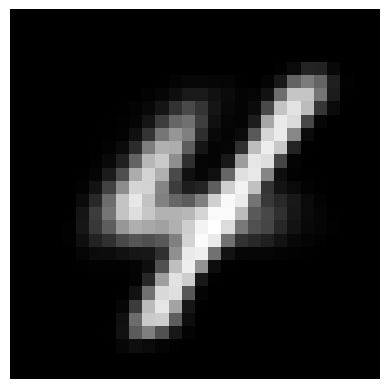

tensor(0.2891) tensor(0.3843)


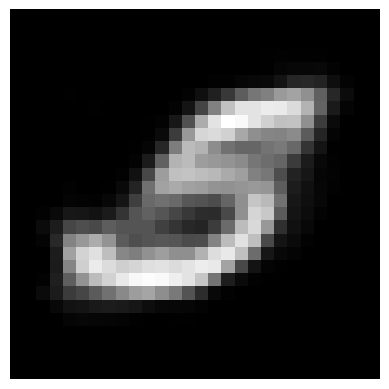

tensor(-0.4721) tensor(-0.0059)


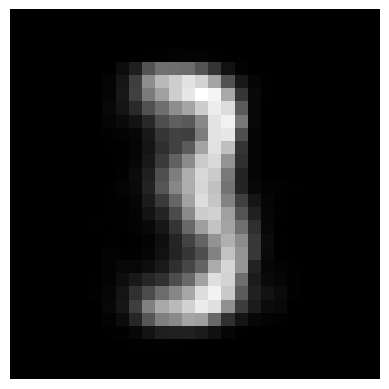

tensor(0.0873) tensor(0.0819)


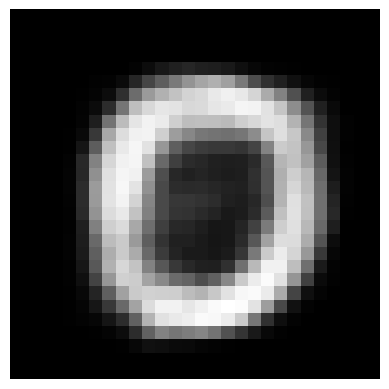

tensor(-0.3469) tensor(-0.1167)


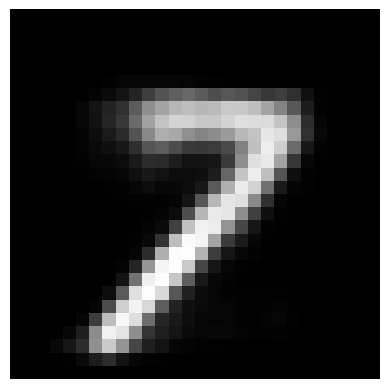

tensor(0.3325) tensor(0.1709)


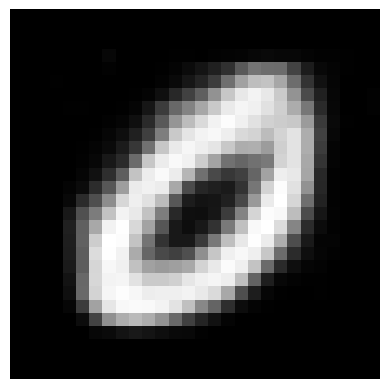

tensor(-0.1913) tensor(0.2726)


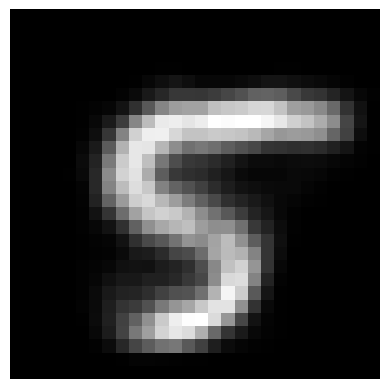

tensor(0.3099) tensor(-0.1393)


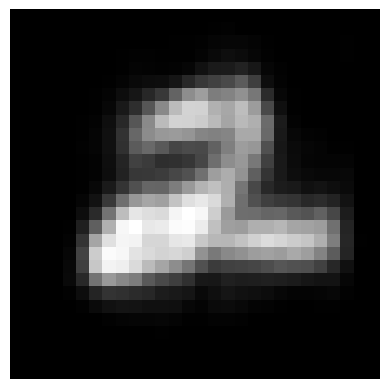

tensor(-0.5000) tensor(-0.0236)


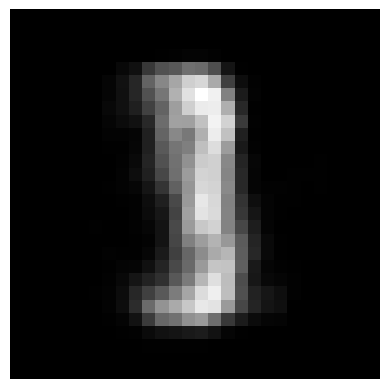

tensor(0.0762) tensor(-0.1211)


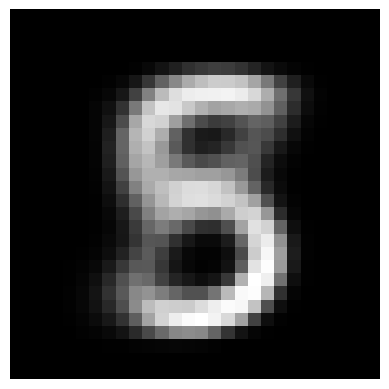

tensor(-0.1391) tensor(-0.0355)


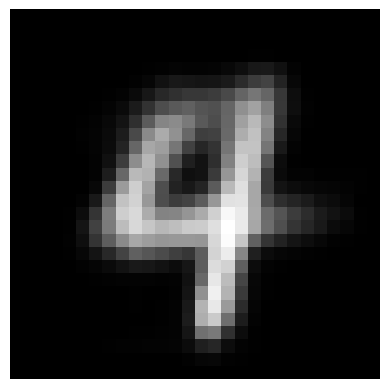

tensor(-0.2412) tensor(0.1708)


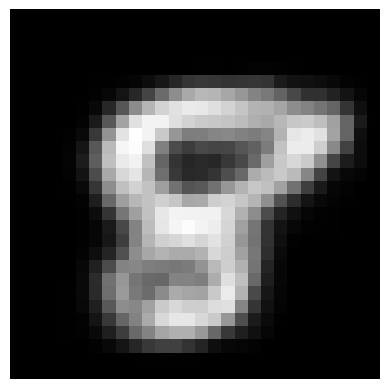

tensor(-0.1378) tensor(0.0707)


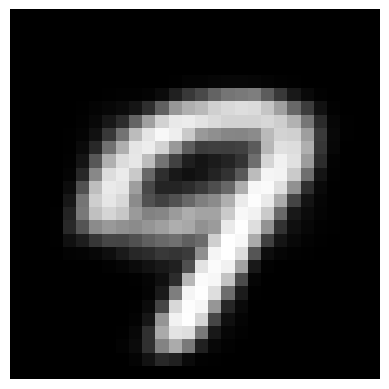

tensor(0.1184) tensor(0.2367)


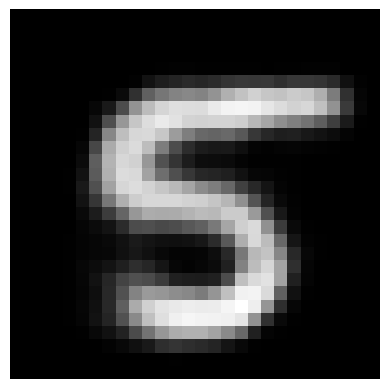

tensor(-0.2168) tensor(-0.0557)


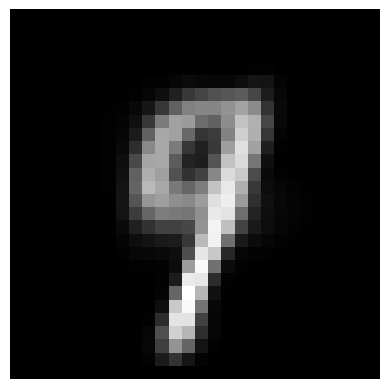

tensor(-0.0108) tensor(0.0263)


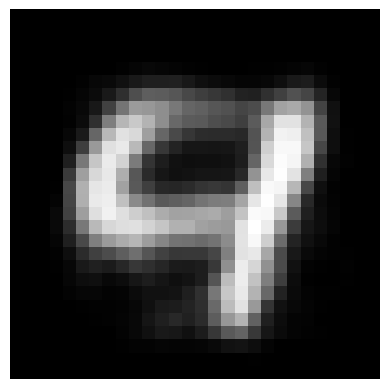

tensor(0.0364) tensor(0.1914)


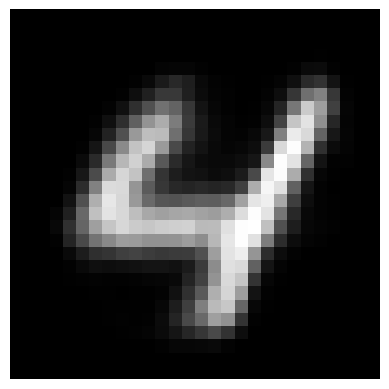

tensor(-0.5000) tensor(-0.1457)


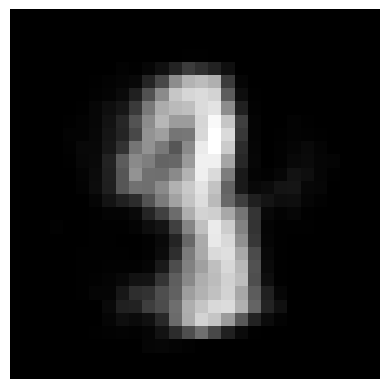

tensor(0.2117) tensor(-0.0266)


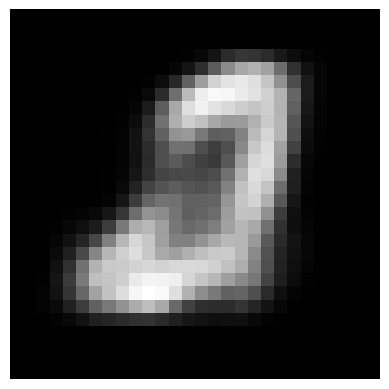

tensor(-0.0463) tensor(-0.2965)


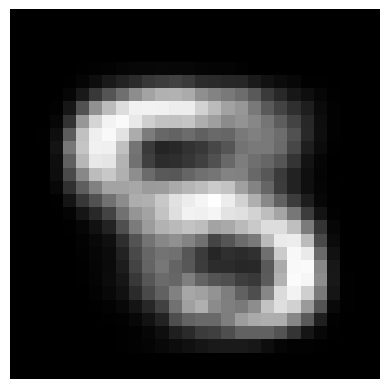

tensor(-0.0378) tensor(-0.0925)


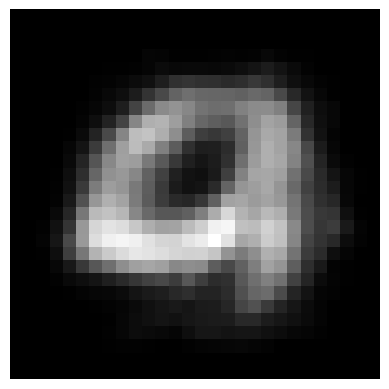

tensor(0.0316) tensor(0.1948)


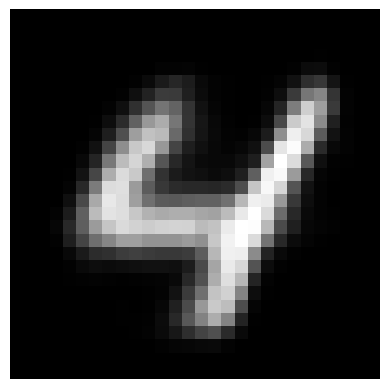

tensor(-0.0385) tensor(-0.1984)


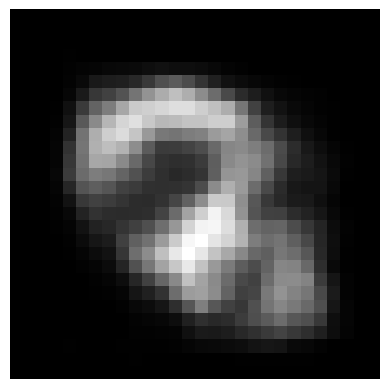

In [496]:
for i in range(50):
    values = torch.normal(mean, std, size=(2,)) 
    clipped_values = torch.clamp(values, min=-0.5, max=0.5)
    mu = clipped_values[0]; var =clipped_values[1]
    print(mu, var)
    generate_digit(mu, var)